In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import Polygon
import pandas as pd
import osmnx as ox
from shapely.ops import split
import geopandas
from shapely.geometry import MultiPolygon, Polygon
from shapely.geometry import LineString
import numpy as np

Ladowanie danych, sprowadzenie do jednego crs i przycinanie

In [2]:
pictures = gpd.read_file("data/podzial_na_obrazki.csv")
noise = gpd.read_file("data/noise.zip")
transport_lines = gpd.read_file("data/transport_lines.zip")

city = "Praha"
roads = ox.graph_from_place(city, network_type="drive")
roads = ox.graph_to_gdfs(roads, nodes=False, edges=True)

In [98]:
default_crs = noise.crs

In [101]:
#sprowadzenie wszystkiego do jednego crs
noise = noise.to_crs(default_crs)
roads = roads.to_crs(default_crs)
transport_lines = transport_lines.to_crs(default_crs)

print("default crs: ", default_crs)
print("noise crs: ", noise.crs)
print("roads crs: ", roads.crs)
print("transport_lines crs: ", transport_lines.crs)

default crs:  EPSG:5514
noise crs:  EPSG:5514
roads crs:  EPSG:5514
transport_lines crs:  EPSG:5514


In [100]:
noise_bounds = noise.unary_union

C:\Users\kajet\AppData\Local\Temp\ipykernel_8628\4229401385.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  noise_bounds = noise.unary_union


In [102]:
#przyciecie wszystko do halasu jaki mamy
transport_lines = gpd.clip(transport_lines, noise_bounds)
roads = gpd.clip(roads, noise_bounds)

Definiowanie wszystkich funkcji pomocniczych

In [6]:
def parse_polygon(polygon_string):
    try:
        # Remove "POLYGON ((" and "))", then split coordinates
        coords_string = polygon_string.replace("POLYGON ((", "").replace("))", "")
        coords = [
            tuple(map(float, coord.split()))  # Convert each pair into a tuple of floats
            for coord in coords_string.split(", ")
        ]
        return Polygon(coords)  # Create Shapely Polygon
    except Exception as e:
        # Handle errors (e.g., malformed strings)
        print(f"Error parsing polygon: {polygon_string}, error: {e}")
        return None

In [12]:
#funkcje do dzielenia zdjecia na piksele
def get_squares_from_rect(RectangularPolygon, side_length=0.0025):
    """
    Divide a Rectangle (Shapely Polygon) into squares of equal area.

    `side_length` : required side of square

    """
    rect_coords = np.array(RectangularPolygon.boundary.coords.xy)
    y_list = rect_coords[1]
    x_list = rect_coords[0]
    y1 = min(y_list)
    y2 = max(y_list)
    x1 = min(x_list)
    x2 = max(x_list)
    width = x2 - x1
    height = y2 - y1

    xcells = int(np.round(width / side_length))
    ycells = int(np.round(height / side_length))

    yindices = np.linspace(y1, y2, ycells + 1)
    xindices = np.linspace(x1, x2, xcells + 1)
    horizontal_splitters = [
        LineString([(x, yindices[0]), (x, yindices[-1])]) for x in xindices
    ]
    vertical_splitters = [
        LineString([(xindices[0], y), (xindices[-1], y)]) for y in yindices
    ]
    result = RectangularPolygon
    for splitter in vertical_splitters:
        result = MultiPolygon(split(result, splitter))
    for splitter in horizontal_splitters:
        result = MultiPolygon(split(result, splitter))
    square_polygons = list(result.geoms)

    return square_polygons

#number of pixel on side to A dla obrazku o wymiarach AxA, zdjecie ma AxA pikseli
def split_polygon(G, number_of_pixels_on_side = 100, thresh=0.99):
    side_length = int(1500 / number_of_pixels_on_side)
    assert side_length>0, "side_length must be a float>0"
    Rectangle    = G.envelope
    squares      = get_squares_from_rect(Rectangle, side_length=side_length)
    SquareGeoDF  = geopandas.GeoDataFrame(squares).rename(columns={0: "geometry"})
    SquareGeoDF.set_geometry('geometry', inplace=True)
    Geoms        = SquareGeoDF[SquareGeoDF.intersects(G)].geometry.values
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]
    return geoms

In [13]:
def calculate_weighted_db(pixel, noise_gdf):
    total_area = pixel.area  # Total area of the square
    weighted_sum = 0  # Weighted sum of DB_HI
    total_weight = 0  # Total weight (should sum to 1 if fully covered)

    for _, noise in noise_gdf.iterrows():
        # Calculate intersection geometry between pixel and noise polygon
        intersection = pixel.intersection(noise.geometry)

        # If there's an intersection, calculate the weight and add to the weighted sum
        if intersection.is_valid and not intersection.is_empty:
            intersection_area = intersection.area
            weight = intersection_area / total_area  # Weight based on area covered
            weighted_sum += weight * noise["DB_HI"]
            total_weight += weight

    # Return the weighted average, default to 0 if there's no coverage
    return weighted_sum if total_weight > 0 else 0

In [49]:
def round_to_nearest_5(value):
    return round(value / 5) * 5

In [41]:
def create_pixels_gdf(picture):
    pixels = split_polygon(picture, number_of_pixels_on_side = 25, thresh=0.99)
    pixels = geopandas.GeoDataFrame(pixels).rename(columns={0: "geometry"})
    pixels.set_geometry('geometry', inplace=True)
    pixels.set_crs(default_crs, inplace=True)
    if pixels.crs is None:
        print("xd")
    if pixels.crs != default_crs:
        print("rip")
    return pixels

In [30]:
def extract_max_speed(maxspeed):
    if isinstance(maxspeed, list):  
        # Convert list to numeric, drop NaN, take the highest value
        maxspeed_values = pd.to_numeric(maxspeed, errors="coerce")
        return max(maxspeed_values, default=-1)  # Return highest speed or -1 if empty
    elif pd.isna(maxspeed):  # If NaN, return -1
        return -1
    return pd.to_numeric(maxspeed, errors="coerce")  # Convert single value to numeric

In [33]:
def get_max_speed(pixel, roads_for_picture):
    intersecting_roads = roads_for_picture[roads_for_picture.geometry.intersects(pixel)]
    
    if not intersecting_roads.empty:
        # Convert 'maxspeed' column to numeric, handle missing values, and find the max
        return pd.to_numeric(intersecting_roads["maxspeed"], errors="coerce").max(skipna=True)
    
    return 0  # If no road is found in the square

Szybkie przyszykowanie datasetow

In [32]:
#czyszczenie kolumny maxspeed z list, zostaje pojedyncze wartosci
roads["maxspeed"] = roads["maxspeed"].apply(extract_max_speed)

In [7]:
pictures = gpd.GeoDataFrame(pictures).rename(columns={0: "geometry"})
pictures["geometry"] = pictures["geometry"].apply(parse_polygon)
pictures.set_geometry('geometry', inplace=True)

In [15]:
pictures.dtypes

geometry    geometry
dtype: object

In [16]:
pictures

,geometry
0,"POLYGON ((-746187.429 -1058799.6, -747663.568 ..."
1,"POLYGON ((-747663.568 -1058799.6, -749139.707 ..."
2,"POLYGON ((-749139.707 -1058799.6, -750615.845 ..."
3,"POLYGON ((-750615.845 -1058799.6, -752091.984 ..."
4,"POLYGON ((-752091.984 -1055715.058, -750615.84..."
...,...
257,"POLYGON ((-740282.874 -1034123.26, -738806.736..."
258,"POLYGON ((-738806.736 -1034123.26, -737330.597..."
259,"POLYGON ((-737330.597 -1034123.26, -735854.458..."
260,"POLYGON ((-735854.458 -1034123.26, -734378.32 ..."


In [23]:
temp_pictures = pictures.head(5)
temp_pictures

,geometry
0,"POLYGON ((-746187.429 -1058799.6, -747663.568 ..."
1,"POLYGON ((-747663.568 -1058799.6, -749139.707 ..."
2,"POLYGON ((-749139.707 -1058799.6, -750615.845 ..."
3,"POLYGON ((-750615.845 -1058799.6, -752091.984 ..."
4,"POLYGON ((-752091.984 -1055715.058, -750615.84..."


petla tworzenia datasetu

In [103]:
for i, picture in enumerate(temp_pictures['geometry']):
    noise_for_picture = gpd.clip(noise, picture)
    roads_for_picture = gpd.clip(roads, picture)
    transport_lines_for_picture = gpd.clip(transport_lines, picture)
    pixels = create_pixels_gdf(picture)

    #liczenie wzonego halasu dla kazdego piksela
    pixels["weighted_db_hi"] = pixels.geometry.apply(lambda pixel: calculate_weighted_db(pixel, noise_for_picture))
    pixels["weighted_db_hi"] = pixels["weighted_db_hi"].apply(round_to_nearest_5)
    #droga z max predkoscia na pixeulu
    pixels["max_speed"] = pixels["geometry"].apply(lambda pixel: get_max_speed(pixel, roads_for_picture))

    #czy pixel posiada transport line
    pixels['has_transport_line'] = pixels.geometry.apply(lambda pixel: transport_lines_for_picture.geometry.intersects(pixel).any())
    #pixels.drop(columns="geometry").to_csv(f"data/pictures/picture_{i}.csv", index=False)
    pixels.to_file(f"data/pictures/picture_{i}.geojson", driver="GeoJSON")

Przykladowy odczyt

In [104]:
read_pixels = gpd.read_file("data/pictures/picture_0.geojson")

In [105]:
read_pixels

,weighted_db_hi,max_speed,has_transport_line,geometry
0,0,0.0,False,"POLYGON ((-746187.429 -1058799.6, -746246.475 ..."
1,0,0.0,False,"POLYGON ((-746246.475 -1058799.6, -746305.52 -..."
2,0,0.0,False,"POLYGON ((-746305.52 -1058799.6, -746364.566 -..."
3,0,0.0,False,"POLYGON ((-746364.566 -1058799.6, -746423.611 ..."
4,0,0.0,False,"POLYGON ((-746423.611 -1058799.6, -746482.657 ..."
...,...,...,...,...
645,0,0.0,False,"POLYGON ((-746482.657 -1057257.329, -746423.61..."
646,0,0.0,False,"POLYGON ((-746423.611 -1057257.329, -746364.56..."
647,0,0.0,False,"POLYGON ((-746364.566 -1057257.329, -746305.52..."
648,0,0.0,False,"POLYGON ((-746305.52 -1057257.329, -746246.475..."


In [106]:
pic = temp_pictures['geometry'][0]

In [107]:
noise_for_pixel = gpd.clip(noise, pic)
roads_for_pixel = gpd.clip(roads, pic)
transport_lines_for_picture = gpd.clip(transport_lines, pic)

In [108]:
read_pixels.crs

<Projected CRS: EPSG:5514>
Name: S-JTSK / Krovak East North
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Czechia; Slovakia.
- bounds: (12.09, 47.73, 22.56, 51.06)
Coordinate Operation:
- name: Krovak East North (Greenwich)
- method: Krovak (North Orientated)
Datum: System of the Unified Trigonometrical Cadastral Network
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [109]:
roads.crs

<Projected CRS: EPSG:5514>
Name: S-JTSK / Krovak East North
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Czechia; Slovakia.
- bounds: (12.09, 47.73, 22.56, 51.06)
Coordinate Operation:
- name: Krovak East North (Greenwich)
- method: Krovak (North Orientated)
Datum: System of the Unified Trigonometrical Cadastral Network
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

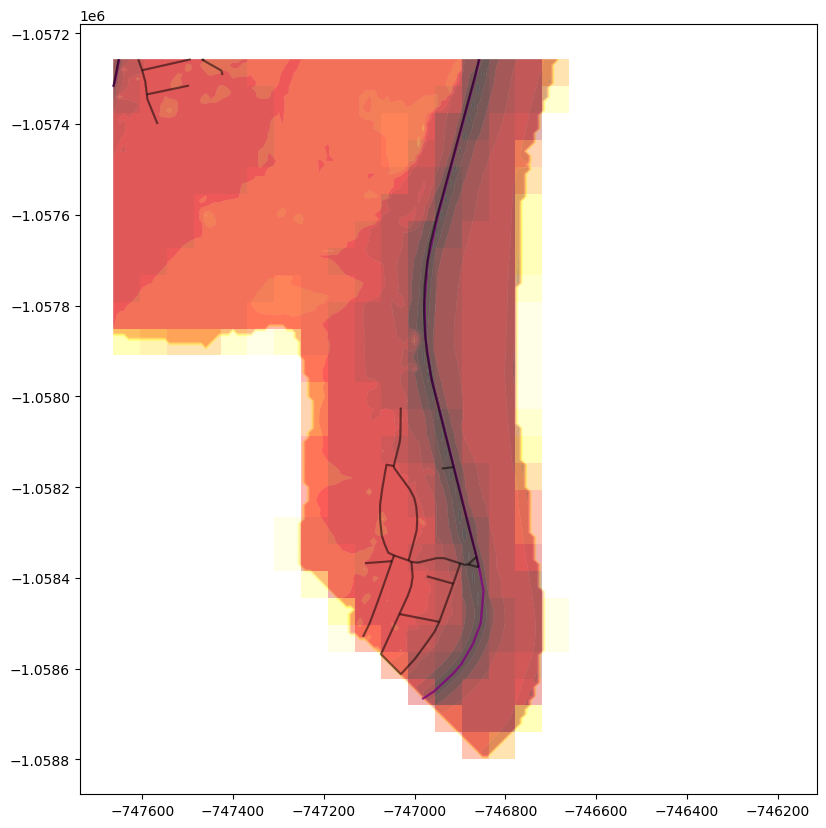

In [112]:
fig, ax = plt.subplots(figsize=(10, 10))

noise_for_pixel.plot(
    column="DB_HI",
    cmap="hot_r",
    scheme="quantiles",
    k=noise.shape[0],
    edgecolor="white",
    linewidth=0.0,
    alpha=0.5,
    ax=ax,
)
transport_lines_for_picture.plot(ax=ax, alpha = 0.3, color="purple",edgecolor="purple", linewidth=1.5)

roads_for_pixel.plot(ax=ax, alpha = 0.3, color="black",edgecolor="black", linewidth=1.5)
read_pixels.plot(column='weighted_db_hi', ax=ax,
            cmap="hot_r", linewidth=0.0, edgecolor="0.8", alpha = 0.3)

plt.show()

C:\Users\kajet\AppData\Local\Temp\ipykernel_8628\2952187598.py:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")


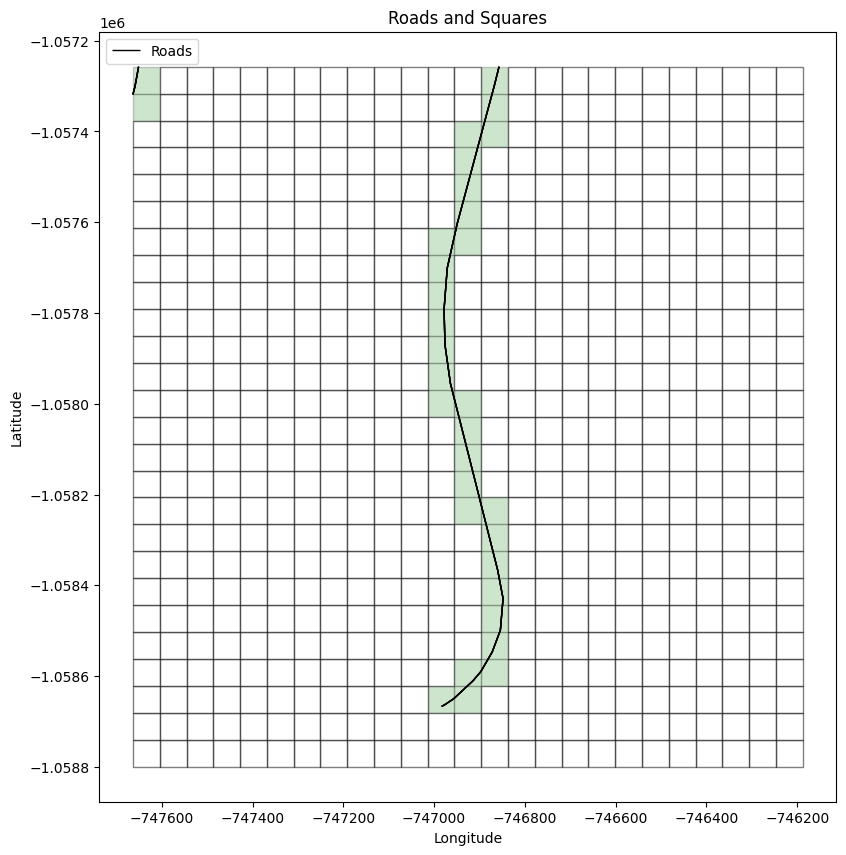

In [111]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the roads in black
transport_lines_for_picture.plot(ax=ax, color="black", linewidth=1, label="Roads")

# Plot the squares that contain roads in green
read_pixels[read_pixels['has_transport_line']].plot(ax=ax, color="green", edgecolor="black", alpha=0.2, label="Squares with Roads")

# Plot the squares that do not contain roads in red
read_pixels[~read_pixels['has_transport_line']].plot(ax=ax, color="white", edgecolor="black", alpha=0.5, label="Squares without Roads")

# Add legend
ax.legend(loc="upper left")

# Add title and labels
ax.set_title("Roads and Squares")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

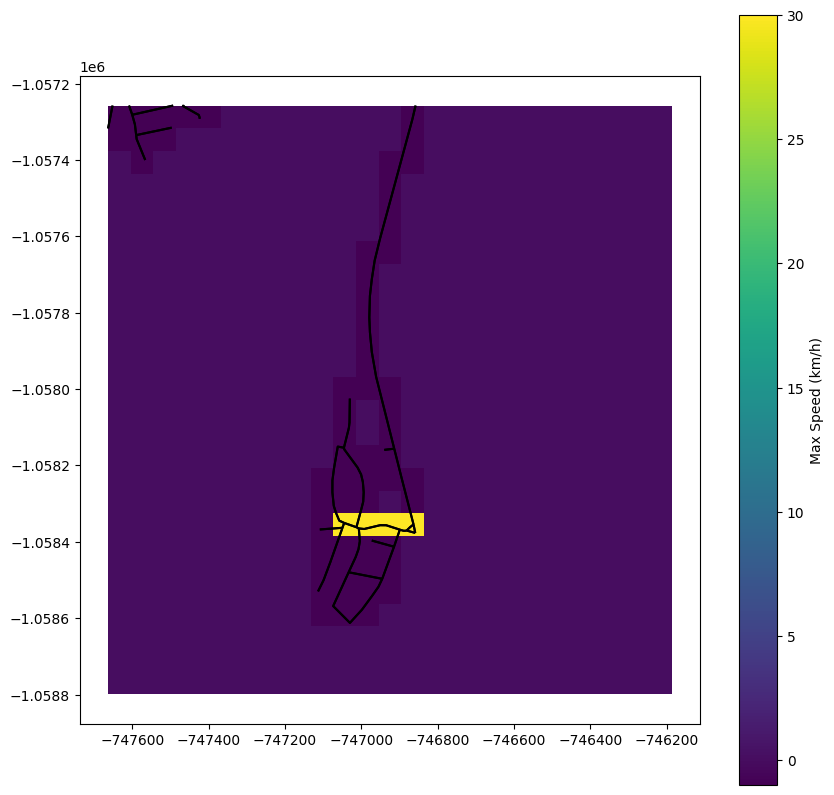

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))

read_pixels.plot(column='max_speed', ax=ax,
            cmap="viridis", linewidth=0.0, edgecolor="0.8", legend=True, legend_kwds={'label': "Max Speed (km/h)", 
                                           'orientation': "vertical"})

roads_for_pixel.plot(ax=ax, alpha = 1, color="black", linewidth=1.5)

plt.show()

In [116]:
read_pixels['max_speed'].unique()

array([ 0., -1., 30.])